# MRI_Skull Stripping

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 14 01:22:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    54W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## 0. Importation de mon google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',  force_remount=True)

Mounted at /content/drive/


## 1. Importing Libraries

In [ ]:
!pip install torchio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torch
import numpy as np
import torchvision
import torchio as tio
import torch as nn
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter 
from datetime import datetime

In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/LIFPROJET/')
import lib

In [ ]:
from lib.data import *
from lib.utils import *
from lib.losses import *
from lib.layers import *
from lib.models import ResidualUNET3D,DenseNet3D
from lib.runners import *

## 2. Data Initialization

In [ ]:
def get_dataset_from_path_all(image_paths: any, label_paths: any, targets_path: any) -> tio.SubjectsDataset:
    '''
    A function to load dataset from the given paths of images and labels (masks)
    Args:
      * image_paths: Directory path of the images
      * label_paths: Directory path of the labels
      * targets_paths: Directory path of the targets
    Returns:
      * dataset: Returns a tio subjects dataset containing images, labels and targets
    '''
    # check if number of smaples are equal or not
    assert len(image_paths) == len(label_paths) == len(targets_path),"Number of samples in images and labels don't match"

    # create an empty list to store the dataset
    subjects = []
    
    # iterate through the image and label paths and store them as Subjects in the list
    for image_path, label_path, targets_path in zip(image_paths, label_paths, targets_path):
        subject = tio.Subject(
            targets=tio.ScalarImage(targets_path),
            mri=tio.ScalarImage(image_path),
            brain=tio.LabelMap(label_path),
        )
        subjects.append(subject)

    # return the images and labels as a subject dataset
    return tio.SubjectsDataset(subjects)

### 2.1 Initialization path and parameters

In [ ]:
# dataset paths
path = Path('/content/drive/MyDrive/LIFPROJET/dataset_SkullStripping')
images_path = path / 'images'
labels_path = path / 'labels'
targets_path = path / 'targets'

# sort the dataset paths
images = sorted(images_path.glob('*.nii.gz'))
labels = sorted(labels_path.glob('*.nii.gz'))
targets = sorted(targets_path.glob('*.nii.gz'))

In [ ]:
print(len(images))
print(len(labels))

125
125


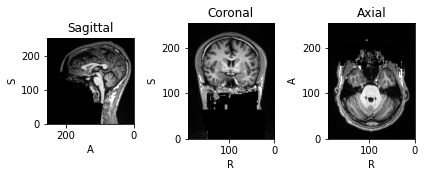

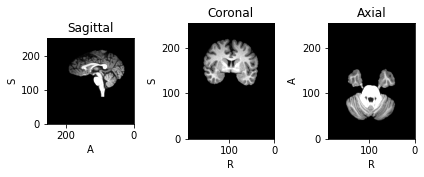

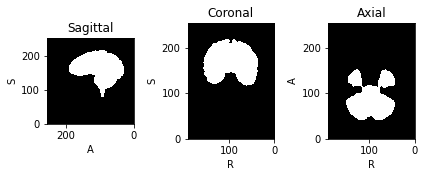

In [ ]:
dataset = get_dataset_from_path_all(images, labels, targets)
a = dataset[0]
a.targets.plot()
a.mri.plot()
a.brain.plot()

In [107]:
# training parameters
batch_size = 8
patch_size = 32
overlap_size = 16
test_size = 0.2
epochs = 12

# tensorboard and model checkpoint paths
model_path = '/content/drive/MyDrive/LIFPROJET/models_SkullStriping'

# create dirs if they don't exist
os.makedirs(model_path, exist_ok=True)

### 2.2.Get Transforms
In the transforms I have included the classes to perform data preprocessing and augmentation.

#### Train Transforms

The train transform contains the follwing transforms:

* **Canonical:** This transform reorders the voxels and modifies the affine matrix so that the voxel orientations are in unified format
* **Resample:** Changes voxel spacing by resampling. Ex: 1mm, 2mm, 4mm, etc. Here we are preserving the inital 1mm voxel spacing
* **Random Motion:** Applies random motion to the MRI iamge to simulate real-time motion of MRI
* **Histogram Standardization:** Standardizes histogram and unifies intensity
* **Random Bias Field:** Applies random bias field to the MRI (low frequency signal)
* **ZNormalization:** Normalizes data with mean and standard deviation
* **Random Noise:** Applies random gaussian noise to the image (grainy MRI)
* **Random Flip:** Apllies random flipping to change vertical and horizontal orientations
* **One Of:** To choose any one transforms from a given list randomly
* **Random Affine:** Apply translations to the image to rotate or move the contents of the image within its own space
* **Random Elastic Deformation:** Applies elastic deformation to the MRI which simulates realtime deformation and formation of the image in MRI scans
* **(Optional): One Hot:** To convert the labels to required numbe rof classes or to foreground and background

In [ ]:
train_transforms = tio.Compose([
        tio.ToCanonical(),
        tio.Resample(1),
        tio.RandomMotion(p=0.3),
        tio.HistogramStandardization({'mri': np.load('/content/drive/MyDrive/LIFPROJET/ressources/NFBS_histogram_landmarks.npy')}),
        tio.RandomBiasField(p=0.3),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean),
        tio.RandomNoise(p=0.49),
        tio.RandomFlip(),
        tio.OneOf({
            tio.RandomAffine(): 0.6,
            tio.RandomElasticDeformation(): 0.4,
        })
    ])

#### Valid Transforms

The valid transform only contains the required preprocessing that can be used for evaluation and inference:

* **Canonical:** This transform reorders the voxels and modifies the affine matrix so that the voxel orientations are in unified format
* **Resample:** Changes voxel spacing by resampling. 1mm, 2mm, 4mm, etc
* **Histogram Standardization:** Standardizes histogram and unifies intensity
* **ZNormalization:** Normalizes data with mean and standard deviation

In [ ]:
valid_transforms = tio.Compose([
        tio.ToCanonical(),
        tio.Resample(1),
        tio.HistogramStandardization({'mri': np.load('/content/drive/MyDrive/LIFPROJET/ressources/NFBS_histogram_landmarks.npy')}),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean)
    ])

### 2.3 Initialization DataLoader

In [ ]:
training_set, validation_set = load_datasets(targets, 
                                             labels, 
                                             patch_size=patch_size, 
                                             volume="patches", 
                                             test_size=test_size, 
                                             train_transforms=train_transforms, 
                                             valid_transforms=valid_transforms, 
                                             random_state=52)


Volume Mode: PATCHES | Dataset: 125 Images
Training set: 12800 Images
Validation set: 3200 Images


In [ ]:
print(training_set)
print(validation_set)

Queue(max_length=128, num_subjects=100, num_patches=0, samples_per_volume=128, iterations_per_epoch=12800)
Queue(max_length=128, num_subjects=25, num_patches=0, samples_per_volume=128, iterations_per_epoch=3200)


In [ ]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size//2)

In [ ]:
print(train_loader)
print(valid_loader)

## 3. Training

### 3.1 Model - Residual UNET 3D

I have used a custom image segmentation architecture created by  aksh-ai and inspired from Residual Networks and UNET for 3D images. Below is the architecture diagram of the model.

![Residual UNET 3D](/content/drive/MyDrive/LIFPROJET/ressources/Residual_UNET_3D.png)

The architecture basically consists of two important blocks:

* Residual Block

![Residual Block](/content/drive/MyDrive/LIFPROJET/ressources/residual_block.png)

* Upscaling Block

![Upscaling Block](/content/drive/MyDrive/LIFPROJET/ressources/upscale_block.png)

This architecture is a success because of 4 reasons:

* **Residualization -** Residualization is the process of adding source tensor and feature extracted tensor to preserve the features from both source as well as extracted features. In this case, even if the feature extraction is bad in the current layer, residualization allows the next layer to learn features better without subsequential degradation of the network during forward and backward propagation (inspired from ResNet)
* **Optional Skip -** In the network, there is an optional skip connection in the beginning before applying the residual blocks. This can be done or not done based on the complexity of the image as well as inital performance of the model
* **Same Level Skips -** The tensors from downsampling and upsampling layers from the same level are concatenated and processed inorder to get better performance at segmentation (inspired form UNET)
* **Instance Normalization -** Normalization is done for each sample in the batch spatially and independently

Instantiate the model and set parallization for multi-gpu training (if available)

In [108]:
device = "cuda:0"
device = torch.device(device)

In [109]:
model = ResidualUNET3D(in_channels=1, out_channels=1, optional_skip=True)
model = torch.nn.DataParallel(model).to(device)
MODEL_NAME = "ResidualUNET3D_Adam_10_DiceLoss_3"
model

DataParallel(
  (module): ResidualUNET3D(
    (conv1_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (norm1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (act1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv1_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (conv1_short): Conv3d(1, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (residual_block1): ResidualBlock3D(
      (norm1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act1): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (norm2): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act2): LeakyReLU(negative_slope=0.2, inplace=True)
      (drop1): Dropout(p=0.2, inplace=False)
      (con

In [ ]:
total_parameters = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable = total_parameters - trainable
print(f"Number of parameters in the model: {total_parameters}")
print(f"Number of trainable parameters in the model: {trainable}")
print(f"Number of non-trainable parameters in the model: {non_trainable}")

Number of parameters in the model: 35379008
Number of trainable parameters in the model: 35379008
Number of non-trainable parameters in the model: 0


### 3.2 Function parameters

In [ ]:
criterion = DiceLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 4e-5)

### 3.3 Initilize Tensorboard

In [ ]:
log_dir = "/content/drive/MyDrive/LIFPROJET/logs2/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + MODEL_NAME
tensorboard = SummaryWriter(log_dir)

### 3.4 Train model

In [ ]:
train_loss, valid_loss = train(train_loader, 
                                        valid_loader, 
                                        model, 
                                        optimizer, 
                                        criterion, 
                                        epochs,
                                        device = device, 
                                        scheduler=scheduler, 
                                        experiment=tensorboard, 
                                        verbose=1, 
                                        model_path=os.path.join(model_path, MODEL_NAME))

Streaming output truncated to the last 5000 lines.
Validation - Batch [   214/400] | Loss: 0.014376 | Dice Coefficient: 0.985624 | Jaccard (IoU) Score: 0.971656
Validation - Batch [   215/400] | Loss: 0.016975 | Dice Coefficient: 0.983025 | Jaccard (IoU) Score: 0.966616
Validation - Batch [   216/400] | Loss: 0.015200 | Dice Coefficient: 0.984800 | Jaccard (IoU) Score: 0.970055
Validation - Batch [   217/400] | Loss: 0.019170 | Dice Coefficient: 0.980830 | Jaccard (IoU) Score: 0.962382
Validation - Batch [   218/400] | Loss: 0.018617 | Dice Coefficient: 0.981383 | Jaccard (IoU) Score: 0.963447
Validation - Batch [   219/400] | Loss: 0.016764 | Dice Coefficient: 0.983236 | Jaccard (IoU) Score: 0.967025
Validation - Batch [   220/400] | Loss: 0.024738 | Dice Coefficient: 0.975262 | Jaccard (IoU) Score: 0.951718
Validation - Batch [   221/400] | Loss: 0.018672 | Dice Coefficient: 0.981328 | Jaccard (IoU) Score: 0.963341
Validation - Batch [   222/400] | Loss: 0.015290 | Dice Coefficient: 

In [102]:
torch.save(model.state_dict(),"/content/drive/MyDrive/LIFPROJET/logs/ResidualUNET3D_Adam_10_3.pth")

## 4. Evaluation

In [110]:
model.load_state_dict(torch.load("/content/drive/MyDrive/LIFPROJET/logs/ResidualUNET3D_Adam_10_3.pth"))

<All keys matched successfully>

In [111]:
loss, dice, iou = evaluate(valid_loader, model, criterion, device)
print(f"Overall Validation Metrics - Loss: {loss:.6f} Dice: {dice:.6f} IOU: {iou:.6f}")

Overall Validation Metrics - Loss: 0.019821 Dice: 0.980179 IOU: 0.961247


Overall Validation Metrics - Loss: 0.019821 Dice: 0.980179 IOU: 0.961247

## 5. Test Prediction

In [ ]:
test_images = ['/content/drive/MyDrive/LIFPROJET/dataset_SkullStripping/images/sub-A00028185_ses-NFB3_T1w_brain.nii.gz',
               '/content/drive/MyDrive/LIFPROJET/dataset_SkullStripping/images/sub-A00028352_ses-NFB3_T1w_brain.nii.gz']
saved_imgs = []

Test set evaluation
Image: /content/drive/MyDrive/LIFPROJET/dataset_SkullStripping/images/sub-A00028185_ses-NFB3_T1w_brain.nii.gz


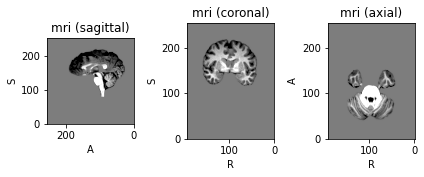

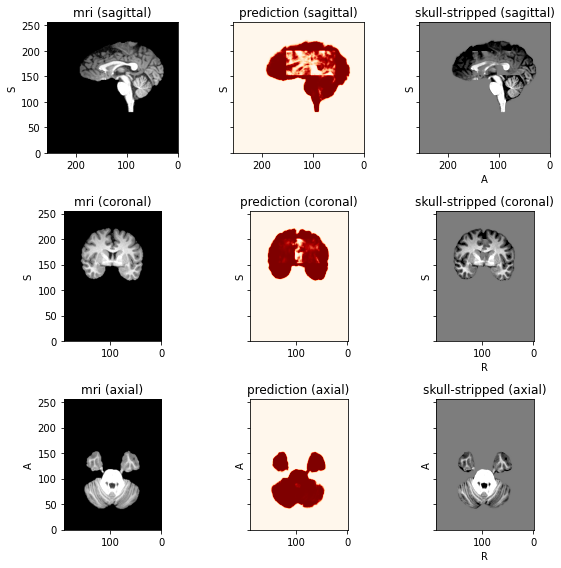

Image: /content/drive/MyDrive/LIFPROJET/dataset_SkullStripping/images/sub-A00028352_ses-NFB3_T1w_brain.nii.gz


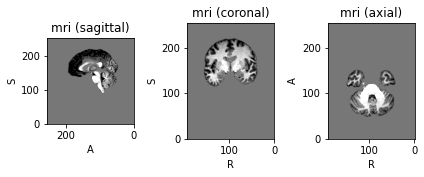

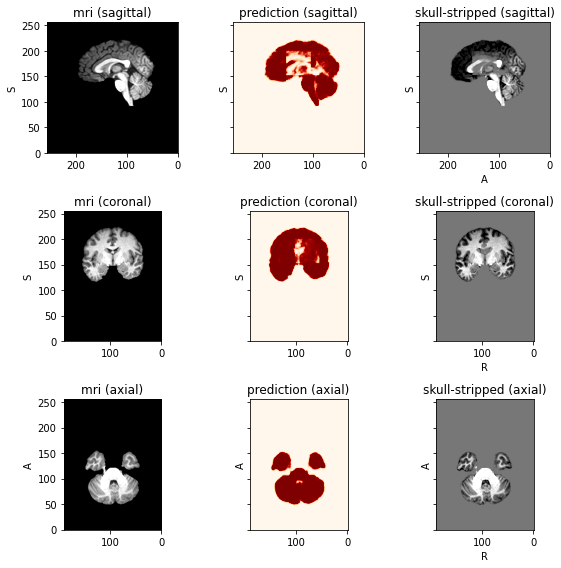

In [ ]:
print("Test set evaluation")
for image in test_images:
  print(f"Image: {image}")
  save_path = image.split('.')[0] + '_skull_stripped.nii.gz'
  saved_imgs.append(save_path)

  original, stripped, mask = infer(image, save_path, model, patch_size=patch_size, overlap=overlap_size, batch_size=batch_size, device=device, visualize=True, return_tensors=True, transforms=valid_transforms)

  subject = tio.Subject(mri=tio.ScalarImage(tensor=original))
  subject.add_image(tio.ScalarImage(tensor=mask), 'prediction')
  subject.add_image(tio.ScalarImage(tensor=stripped), 'skull-stripped')
  subject.plot(figsize=(9, 8), cmap_dict={'prediction': 'OrRd'})